# RFSoC-PYNQ Multi-Tile Sync Acquisition Design
---

This overlay demonstrates Multi-Tile Synchronization (MTS) on the RFSoC4x2 board.
<p align="center">
  <img src="https://www.realdigital.org/img/b228828ef9555df47b6dc0bca8e38f90.png" width="28%" />
</p>

## Board Silkscreen Mappings: 
* DAC A -> DAC Tile 230 Channel 0
* DAC B -> DAC Tile 228 Channel 0
* ADC A -> ADC Tile 226 Channel 0
* ADC B -> ADC Tile 226 Channel 1
* ADC C -> ADC Tile 224 Channel 0
* ADC D -> ADC Tile 224 Channel 1

## Design Overview
This overlay uses one DAC waveform generator that is broadcast to multiple RF DAC tiles.  Samples entering at SMA ports labeled ADC B and D are captured to internal memories storing 64 kilo-samples.  ADC A is stored to the PL DRAM allowing for a greater number of samples.  A simplified block diagram is presented below.
<p align="center">
  <img src="./images/Overlay_simplifiedBlockDiagram.png" width="30%" />
</p>
<div class="alert alert-block alert-danger">Because of the clocking strategy used in this overlay it is best run after first power-cycling your board.</div>

In [1]:
from rfsoc_mts import mtsOverlay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ol = mtsOverlay('mts.bit')

# Generate Waveforms for Loopback
 This overlay uses a single waveform memory that is broadcast to multiple DAC tiles.
### Prepare the DAC Memory
The cell below generates examples waveforms and has customizable paramters.  For example, one can adjust the center frequency, Fc, and re-generate a sinewave.

In [3]:
from scipy.signal import chirp
from scipy.signal import sawtooth
from scipy.signal import gausspulse

DAC_SR = 4.0E9  # Sample rate of DACs and ADCs is 4.0 GHz
ADC_SR = 4.0E9
Fc = 250.0E6 # Set center frequency of waveform to 250.0 MHz
Fe = 500.0E6 # maximum frequency of chirp at end of record
DAC_Amplitude = 16383.0  # 14bit DAC +16383/-16384
X_axis = (1/DAC_SR) * np.arange(0,ol.dac_player.shape[0])

In [4]:
# generate some basic waveforms
DAC_sinewave = DAC_Amplitude * np.sin(2*np.pi*Fc*X_axis)
DAC_sawtooth = DAC_Amplitude * sawtooth(2 * np.pi * Fc * X_axis)
DAC_chirp = DAC_Amplitude * chirp(np.arange(0, ol.dac_player.shape[0])/DAC_SR,
                                  f0=Fc, f1=Fe, t1=(ol.dac_player.shape[0]/DAC_SR), 
                                  phi=0.0, method='linear')

In [5]:
ol.dac_player[:] = np.int16(DAC_sinewave)
#ol.dac_player[:] = np.int16(DAC_sawtooth)
#ol.dac_player[:] = np.int16(DAC_chirp)

---

## Capture DAC Waveform to Internal Memory
The DAC waveform is saved to an internal memory for verification purposes.

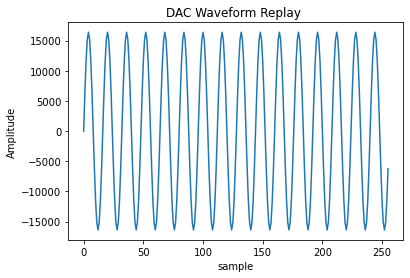

In [6]:
pNumSamples = 256
pS = 0

ol.trigger_capture()
plt.title('DAC Waveform Replay ')
plt.xlabel('sample')         
plt.ylabel('Amplitude')
plt.plot(ol.dac_capture[pS:pNumSamples])
plt.show()
# Note that the waveform is NOT aligned to sample zero of the DACRAM as it is free-running

---

# Non-Aligned ADC Capture and Analysis
Without MTS enabled, the DAC output and ADC samples captured may not be phase-aligned.  For this experiment, wire your RFSoC4x2 as shown in the figure below.
<p align="center">
  <img src="./images/SMAwiring_differentTiles.JPG" width="50%" />
</p>
In this wiring configuration, DAC_A is connected to ADC_B (red) and DAC_B is connected to ADC_D (blue).  DAC channels A and B are driven by different tiles (0 and 2,note 1 is unused).  ADC channels C and D are captured by Tile 0, but ADC channels A and B by Tile 2.  MTS is necessary to generate and capture phase aligned samples.  

In [7]:
ol.init_tile_sync()
nonAlignedCaptureSamples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)
ol.verify_clock_tree()

In [8]:
ol.internal_capture(nonAlignedCaptureSamples)
nonAlignedCaptureSamples[0][:]=-nonAlignedCaptureSamples[0][:]  # correct for the RFSoC4x2 polarity swap of Tile224 ch0 ADC_D
# tile 226 ch0,ch1 labeled ADC_B, ADC_A are fine

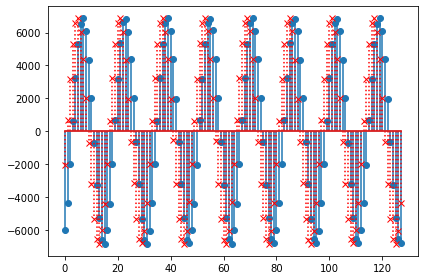

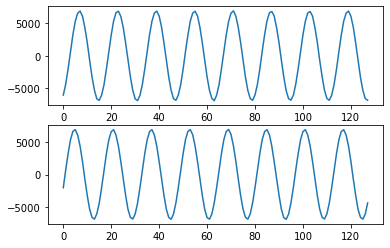

In [9]:
p_start = 0
p_num_samples = 128

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.stem(nonAlignedCaptureSamples[0][p_start:p_start+p_num_samples])
axes.stem(nonAlignedCaptureSamples[2][p_start:p_start+p_num_samples], linefmt='r:', markerfmt='rx')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(nonAlignedCaptureSamples[0][p_start:p_start+p_num_samples])
axes[1].plot(nonAlignedCaptureSamples[2][p_start:p_start+p_num_samples])
plt.show()

# Analysis of the Non-Aligned Captured Waveforms
DAC channels A and B are from different tiles but driven by a common waveform memory just programmed in the cells above.  The outputs should likely appear out of phase with respect to one another despite being captured by the same ADC tile. Even though these two channels are captured with the same ADC tile sometimes they require further alignment via MTS. Performing MTS only on the DAC tiles would correct this.

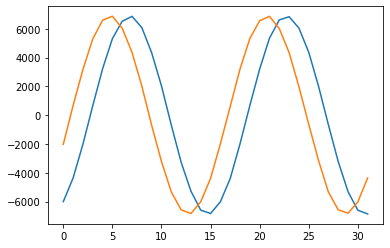

In [10]:
p_start = 0
p_num_samples = 32
plt.plot(nonAlignedCaptureSamples[0][p_start:(p_start+p_num_samples)])
plt.plot(nonAlignedCaptureSamples[2][p_start:(p_start+p_num_samples)])
plt.show()

---

# Enable Multi-Tile Synchronization - MTS
With Multi-Tile Synchronization enabled, the DAC outputs and ADC samples are aligned.  This feature of the RFSOC allows coherency across DAC and ADC tiles.  The RF tiles are reset and their internal FIFOs reset via "init_tile_sync" while also testing if the synthesizer clocks are ready.  Once initialized, the "sync_tiles" function begins the synchronization procedure of the tiles. The results are analyzed below.

In [11]:
ol.init_tile_sync()
ol.verify_clock_tree()

In [12]:
ol.sync_tiles()
AlignedCaptureSamples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)

In [13]:
ol.internal_capture(AlignedCaptureSamples)
AlignedCaptureSamples[0][:]=-AlignedCaptureSamples[0][:]  # correct for the RFSoC4x2 polarity swap of Tile224 ch0 ADC_D
# tile 226 ch0,ch1 labeled ADC_B, ADC_A are fine

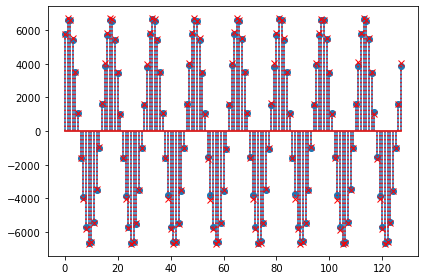

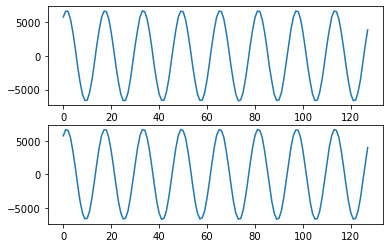

In [14]:
p_start = 0
p_num_samples = 128

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.stem(AlignedCaptureSamples[0][p_start:p_start+p_num_samples])
axes.stem(AlignedCaptureSamples[2][p_start:p_start+p_num_samples], linefmt='r:', markerfmt='rx')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(AlignedCaptureSamples[0][p_start:p_start+p_num_samples])
axes[1].plot(AlignedCaptureSamples[2][p_start:p_start+p_num_samples])
plt.show()

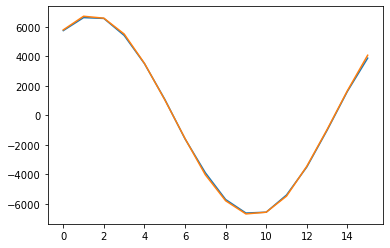

In [15]:
p_start = 0
p_num_samples = 16
plt.plot(AlignedCaptureSamples[0][p_start:(p_start+p_num_samples)])
plt.plot(AlignedCaptureSamples[2][p_start:(p_start+p_num_samples)])
plt.show()

## Latency Incurred Due To Alignment
Enabling MTS adds additional latency in the received sample datapath.  Due to the alignment process one or more streams will be delayed N number of samples and that is reported below in the "Latency Reporting".

In [16]:
MAX_ADC_TILES = 4
MAX_DAC_TILES = 4

for n, is_active in enumerate(bin(ol.ACTIVE_ADC_TILES)[-MAX_ADC_TILES:][::-1]):
    if is_active == '1':
        print(f"Latency DAC Tile {n}: {ol.xrfdc.mts_dac_config.Latency[n]}")

for n, is_active in enumerate(bin(ol.ACTIVE_DAC_TILES)[-MAX_DAC_TILES:][::-1]):
    if is_active == '1':
        print(f"Latency ADC Tile {n}: {ol.xrfdc.mts_adc_config.Latency[n]}")

Latency DAC Tile 0: 120
Latency DAC Tile 2: 120
Latency ADC Tile 0: 88
Latency ADC Tile 2: 88


## Verify Alignment Stability
Perform the correlation of the two non-adjacent channels and verify the sinewaves are in alignment

In [17]:
from scipy import signal

iterations = 16
for i in range(iterations):
    ol.internal_capture(AlignedCaptureSamples)
    N = len(AlignedCaptureSamples[0])  # choose power of two for efficiency
    Tile0 = -AlignedCaptureSamples[0][:N]/2**15
    TileN = AlignedCaptureSamples[2][:N]/2**15
    x_corr = signal.fftconvolve(TileN, Tile0[::-1], mode='full')  # compute the cross corrleation of non-adjacent channels
    lag0 = np.argmax(x_corr)
    failed = False
    if (lag0 != (N-1)):
        failed = True
        print("Failed at ", i, " : MTS Alignment is not stable - please power-cycle board and verify board connections...")
        pStart = 0
        pNumSamples = 16
        plt.plot(AlignedCaptureSamples[0][pStart:(pStart+pNumSamples)])
        plt.plot(AlignedCaptureSamples[2][pStart:(pStart+pNumSamples)])
        plt.show()
        break
if not failed :
    print("MTS Successful")

MTS Successful


---

# Deep Capture to PL DDR4 Memory
The RFSoC4x2 has an additional DRAM exclusively for the PL.  Specifically, this overlay stores "ADC A" samples that are captured at ADC Tile 226 - channel 1 samples. Our overlay limits a DMA descriptor to a maximum length of 24bit or 16MB.

To capture to the PL-DRAM disconnect ADC_B and connect to ADC_A.  Your wiring should make the figure below.  You may leave ADC_D connected or remove it as it is not used in these cells.
<p align="center">
  <img src="./images/SMAwiring_deepcapture.JPG" width="50%" />
</p>

In [18]:
from pynq import allocate
numSamplesPerDMA = (8 << 20) # 8MSamples = 16MB
dbuf = allocate(numSamplesPerDMA, dtype=np.int16, target=ol.ddr4_0)
assert (dbuf.physical_address == ol.ddr4_0.base_address), "Buffer was not allocated to the expected PL-DRAM!"

In [19]:
ol.dram_capture(dbuf)

## Plot Captured ADC Samples from PL DRAM
The DMA interface captures 2MB worth of sample data and saved it into PL DRAM.  Each sample is 2 bytes each (int16) and we have allocated one mega-sample.

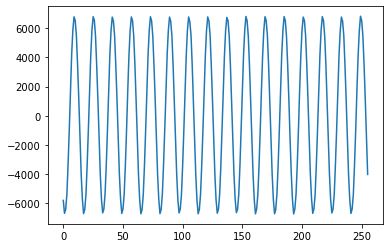

In [20]:
pStart = 32 * (1<<10); # start 32k samples into the buffer
pNumSamples = 256
plt.plot(ol.ADCdeepcapture[pStart:(pStart+pNumSamples)])
plt.show()

In [21]:
dbuf.freebuffer() # reclaim memory
del dbuf

## Verify Waveform Properties Match Expectations

If the DAC waveform was a sinewave, verify the captured ADC waveform is sinusoidal.  If a chirp, verify linear frequency ramping of the captured signal or plot the magnitude of the FFT.  Return to earlier cells and try different waveform generation functions and observe the captured ADC samples to the deep memory.  The DMA interface is limited to a maximum of 64MB per descriptor, so it is not feasible to attempt writing the entire DRAM.  One can modify the cells above to target different regions of the DRAM and deposit more sample sets for analysis.

---
Copyright (C) 2023 Advanced Micro Devices, Inc
SPDX-License-Identifier: MIT
---